In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))

class KNNRegressor:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
    
    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)
    
    def predict(self, X_test):
        X_test = np.array(X_test)
        predictions = []
        for x in X_test:
            distances = euclidean_distance(self.X_train, x)
            nearest_indices = distances.argsort()[:self.n_neighbors]
            nearest_values = self.y_train[nearest_indices]
            predictions.append(np.mean(nearest_values, axis=0))
        return np.array(predictions)

In [13]:
# Data Loading
path = "dataset/ENB2012_data.xlsx"
energy = pd.read_excel(path)

In [14]:
# Rename columns
energy.rename(columns={
    'X1': 'Relative_Compactness', 'X2': 'Surface_Area', 'X3': 'Wall_Area', 'X4': 'Roof_Area',
    'X5': 'Overall_Height', 'X6': 'Orientation', 'X7': 'Glazing_Area',
    'X8': 'Glazing_Area_Distribution', 'Y1': 'Heating Load', 'Y2': 'Cooling Load'
}, inplace=True)

In [16]:
# Remove missing values
energy = energy.loc[(energy[['Glazing_Area', 'Glazing_Area_Distribution']] != 0).all(axis=1)]


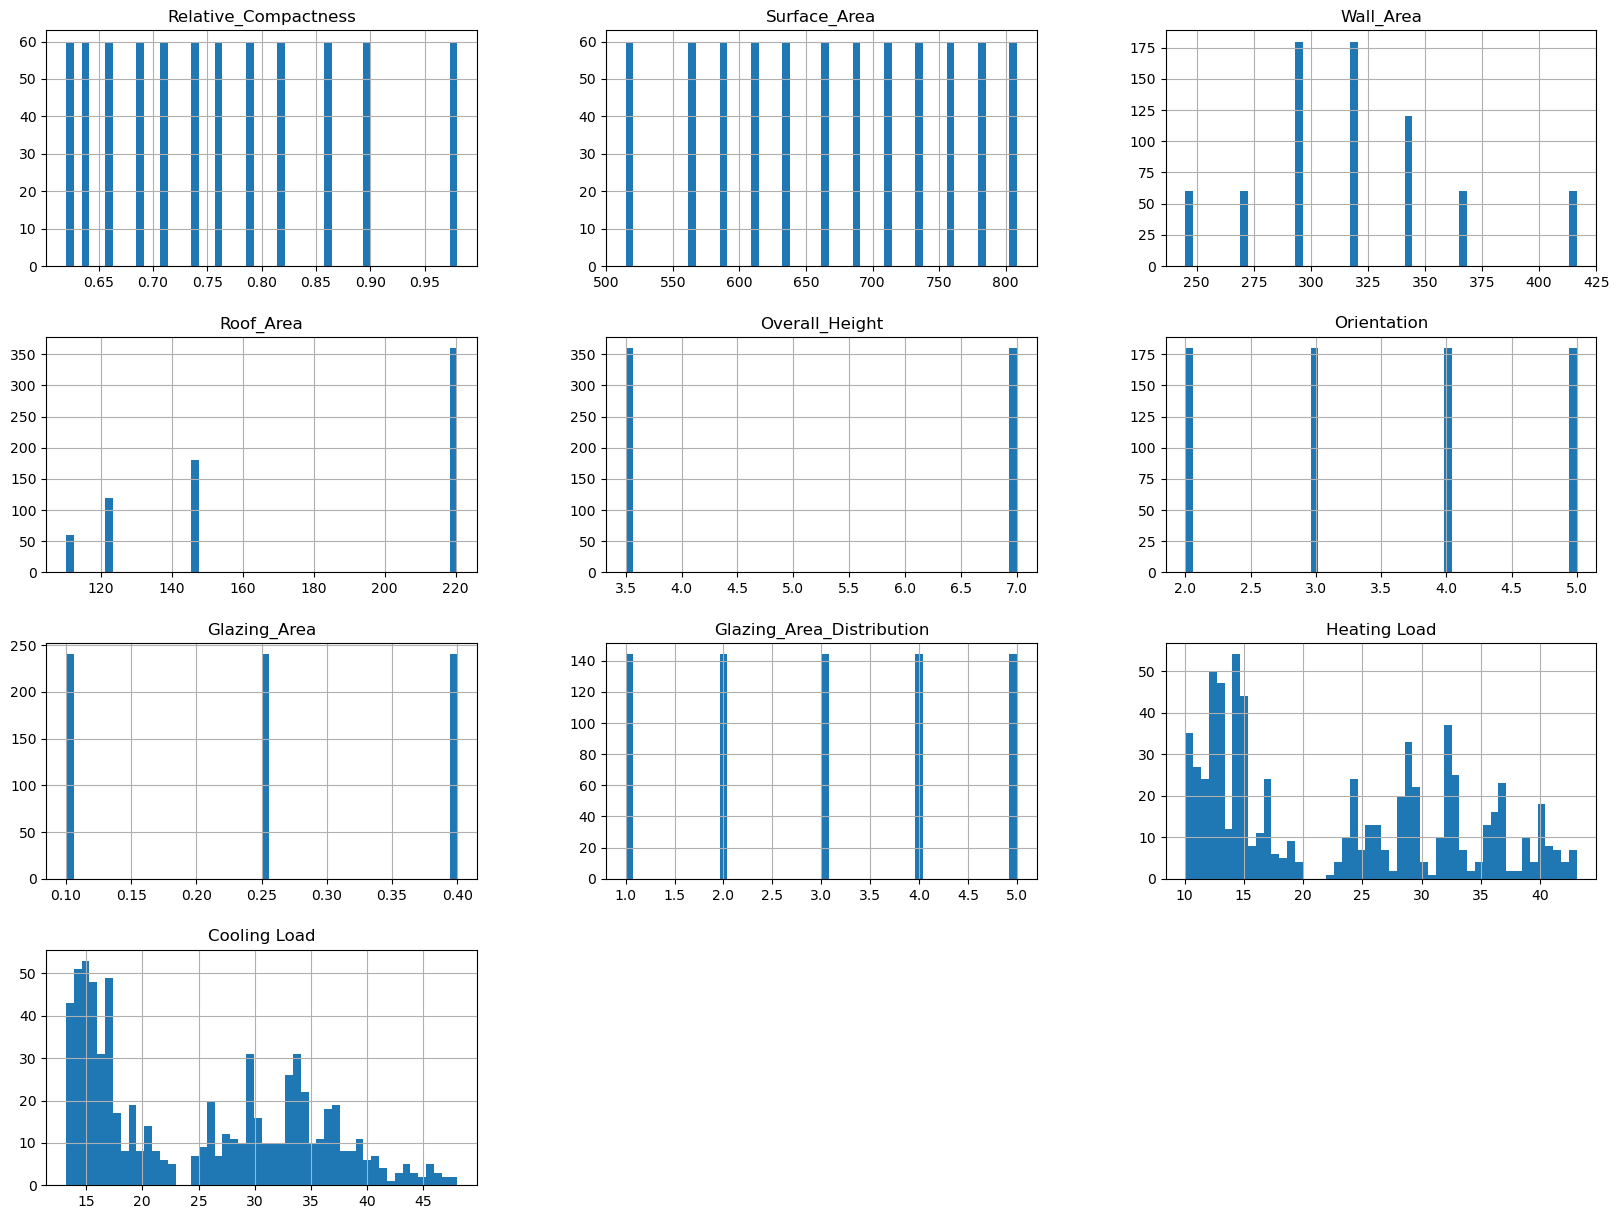

In [17]:
# EDA
# Univariate Analysis
numeric_energy = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating Load', 'Cooling Load']
energy[numeric_energy].hist(bins=50, figsize=(20,15))
plt.show()

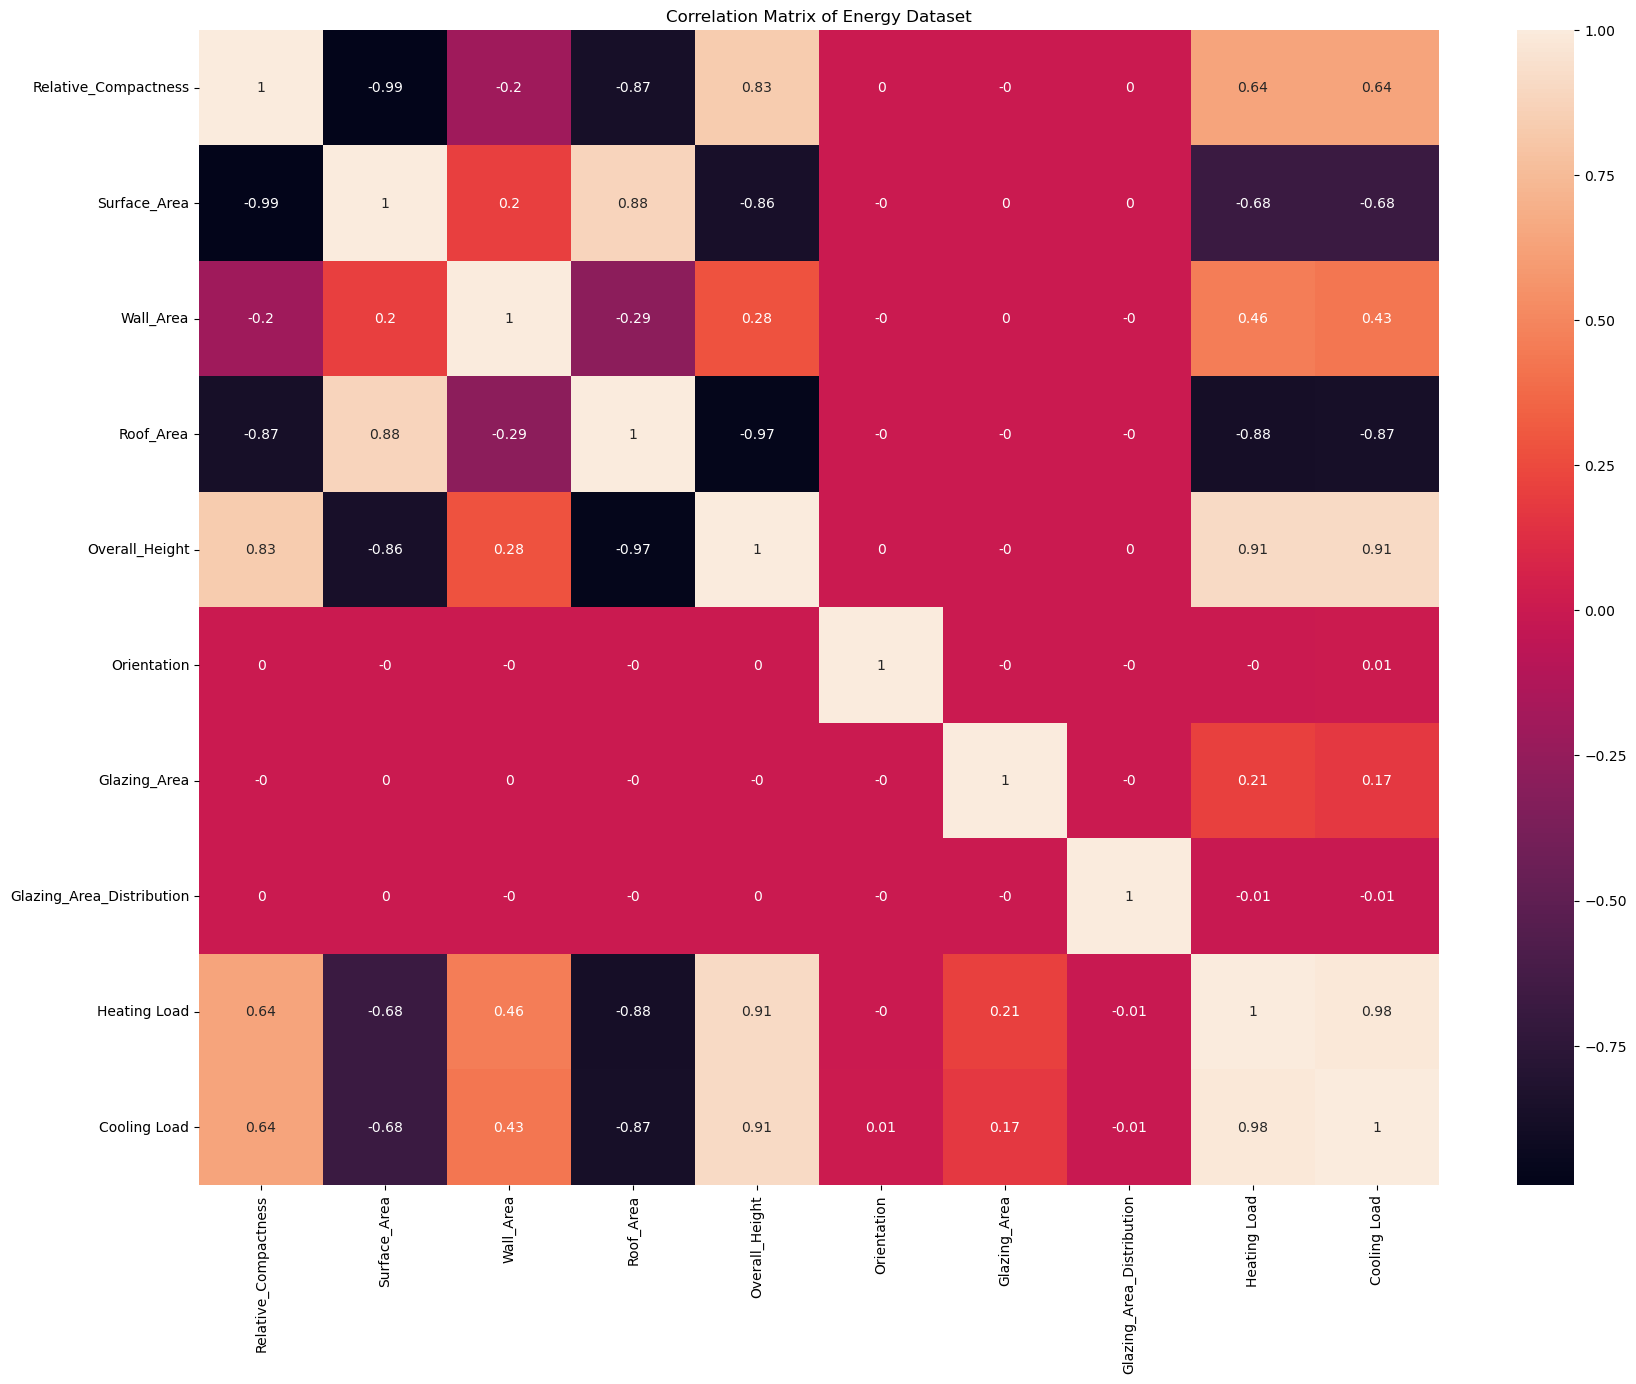

In [18]:
# Correlation matrix
plt.figure(figsize=(20,15))
correlation_matrix = energy.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)
plt.title("Correlation Matrix of Energy Dataset")
plt.show()

In [19]:
# Splitting data manually
np.random.seed(123)
indices = np.random.permutation(len(energy))
split = int(len(energy) * 0.8)
train_idx, test_idx = indices[:split], indices[split:]

X = energy.drop(columns=['Heating Load', 'Cooling Load']).values
y = energy[['Heating Load', 'Cooling Load']].values

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [20]:
# Normalization (Z-score Standardization)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [25]:
X_train_df = pd.DataFrame(X_train, columns=energy.drop(columns=['Heating Load', 'Cooling Load']).columns)
print(X_train_df.describe().round(4))

       Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  \
count              576.0000      576.0000   576.0000   576.0000   
mean                 0.0000       -0.0000    -0.0000     0.0000   
std                  1.0009        1.0009     1.0009     1.0009   
min                 -1.3436       -1.8332    -1.6707    -1.4949   
25%                 -0.9608       -0.7122    -0.5690    -0.8165   
50%                 -0.1952        0.1284    -0.0182     0.9474   
75%                  0.5704        0.9691     0.5327     0.9474   
max                  2.1015        1.5296     2.1852     0.9474   

       Overall_Height  Orientation  Glazing_Area  Glazing_Area_Distribution  
count        576.0000     576.0000      576.0000                   576.0000  
mean          -0.0000       0.0000       -0.0000                    -0.0000  
std            1.0009       1.0009        1.0009                     1.0009  
min           -0.9726      -1.3713       -1.2312                    -1.4174  
25%   

In [21]:
# KNN model training
knn = KNNRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

In [22]:
# Evaluation
train_rmse = root_mean_squared_error(y_train, knn.predict(X_train))
test_rmse = root_mean_squared_error(y_test, knn.predict(X_test))

# Display results
results = pd.DataFrame({'train_rmse': [train_rmse], 'test_rmse': [test_rmse]}, index=['knn'])
print(results)


     train_rmse  test_rmse
knn    1.882784   2.561768


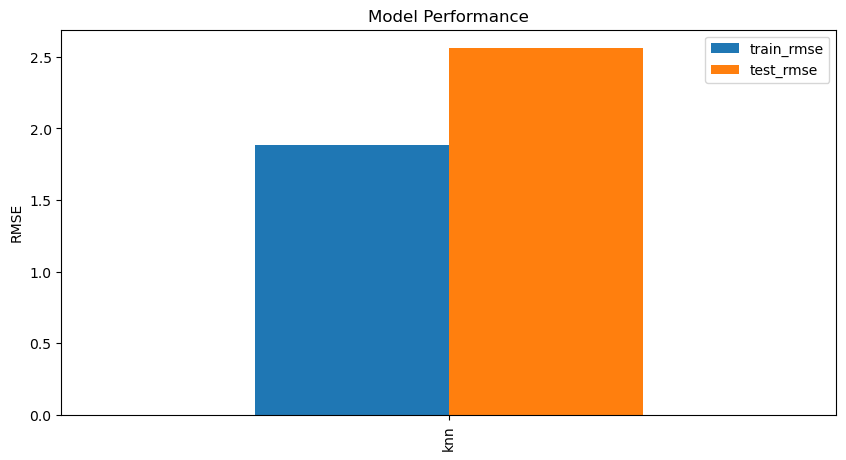

In [23]:
# Plotting results
results.plot(kind='bar', figsize=(10, 5))
plt.title("Model Performance")
plt.ylabel("RMSE")
plt.show()

In [24]:
# Predictions
prediction = X_test[:10]
pred_dict = {
    'Heating Load (true)': y_test[:10, 0],
    'Cooling Load (true)': y_test[:10, 1],
    'KNN_Heating Load (pred)': knn.predict(prediction)[:, 0],
    'KNN_Cooling Load (pred)': knn.predict(prediction)[:, 1]
}
pred_df = pd.DataFrame(pred_dict)
print(pred_df)

   Heating Load (true)  Cooling Load (true)  KNN_Heating Load (pred)  \
0                14.33                15.41                15.040000   
1                30.00                29.93                34.450000   
2                42.62                39.07                38.363333   
3                32.09                31.70                30.983333   
4                12.27                15.27                12.260000   
5                10.64                13.67                10.880000   
6                14.54                16.43                14.373333   
7                32.74                33.88                32.563333   
8                31.66                36.20                30.850000   
9                37.26                34.62                32.283333   

   KNN_Cooling Load (pred)  
0                16.873333  
1                32.150000  
2                35.230000  
3                32.666667  
4                14.776667  
5                13.576667  
6   